# Predicting heart disease using machine learning

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether or not someone has heart disease based on their medical attributes.

We're going to take the following approach:  
1. Problem definition
2. Data
3. Evaluation
4. Features 
5. Modeling 
6. Experimentation

## 1. Problem Definition

In a statement,
> Given clinical parameters about a patient, can we predict whether or not they have heart disease?

## 2. Data

The original data came from the Cleavland data from the UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

There is also a version of it available on Kaggle. https://www.kaggle.com/ronitf/heart-disease-uci

## 3. Evaluation

> If we can reach 95% accuracy at predicting whether or not a patient has heart disease during the proof of concept, we'll pursue the project.

## 4. Features

This is where you'll get different information about each of the features in your data. 

**Create data dictionary**

1. age - age in years
2. sex - (1 = male; 0 = female)
3. cp - chest pain type
    * 1 - typical angina
    * 2 - atypical angina
    * 3 - non-anginal pain
    * 4 - asymptomatic
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
5. chol - serum cholestoral in mg/dl
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7. restecg - resting electrocardiographic results
    * 0 - normal
    * 1 - having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
    * 2 - showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
11. slope - the slope of the peak exercise ST segment
    * 1 - upsloping
    * 2 - flat
    * 3 - downsloping
12. ca - number of major vessels (0-3) colored by flourosopy
13. thal
    * 3 - normal
    * 6 - fixed defect
    * 7 - reversable defect
14. target - 1 or 0


## Preparing the tools

We're going to use pandas, matplotlib, and NumPy for data analysis and manipulation.



In [1]:
# Import all the tools we need

# Regular EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns

# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

Google's Notebook Instances don't come with xgboost out of the box and will need to be installed.

In [2]:
# Import xgboost
try:
    import xgboost as xgb
except ImportError:
    !pip install xgboost

print(xgb.__version__)

1.0.2


In [3]:
import sklearn
print(f"sklearn version: {sklearn.__version__}")

sklearn version: 0.22.2.post1


## Load data

We've already saved the data into a bucket named "heart-disease-data".

In [4]:
df = pd.read_csv("gs://heart-disease-data/heart-disease.csv")

## Data Exploration 

The goal here is to find out more about the data and become a subject matter expert on the dataset you're working with.

1. What question(s) are you trying to solve?
2. What kind of data do we have and how do we treat different types?
3. What's missing from the data and how do you deal with it?
4. What are the outliers and why should you care about them?
5. How can you add, change or remove features to get more out of your data?

In [4]:
df.shape

(303, 14)

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [7]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


All of the features are numeric. Some of those correspond to different levels (e.g. categories), but it's difficult to discern whether or not they are mapped appropriately. 

In [9]:
# Let's find out how many of each class there are
df["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

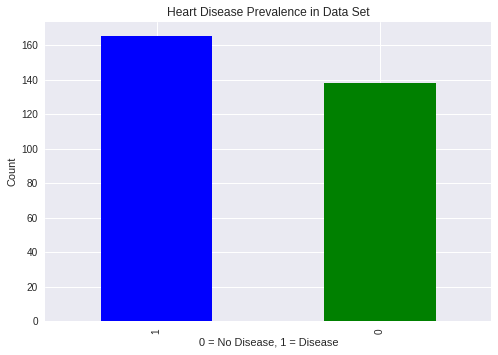

In [10]:
df["target"].value_counts().plot(kind = "bar", color = ["blue", "green"])
plt.title("Heart Disease Prevalence in Data Set")
plt.xlabel("0 = No Disease, 1 = Disease")
plt.ylabel("Count");

In [11]:
# Are there any missing values?
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

### Heart Disease Frequency According to Sex

In [12]:
df.sex.value_counts()

1    207
0     96
Name: sex, dtype: int64

In [13]:
# Compare target column with sex column
pd.crosstab(df.target, df.sex, normalize = 'columns')

sex,0,1
target,,
0,0.25,0.550725
1,0.75,0.449275


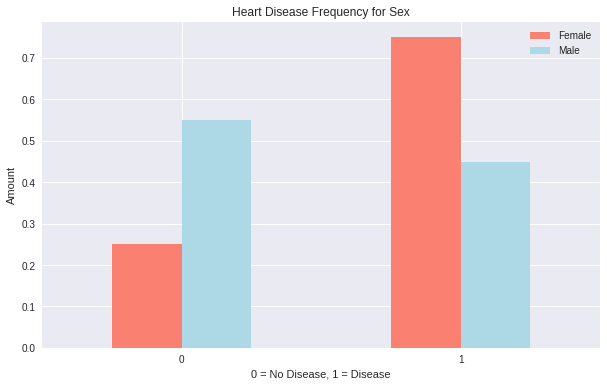

In [14]:
# Create a plot of crosstab
pd.crosstab(df.target, df.sex, normalize = 'columns').plot(kind = "bar",
                                    figsize = (10,6), 
                                    color = ["salmon", "lightblue"])

plt.title("Heart Disease Frequency for Sex")
plt.xlabel("0 = No Disease, 1 = Disease")
plt.ylabel("Amount")
plt.legend(["Female", "Male"]);
plt.xticks(rotation = 0);

Looking strictly at sex, women appear to have a higher rate of heart disease in our dataset. 

### Age vs max Heart Rate for Heart Disease

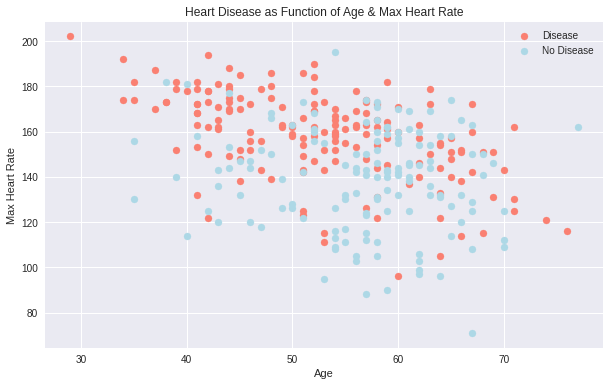

In [15]:
# Create another figure
plt.figure(figsize = (10,6))

# Scatter with positive examples
plt.scatter(df.loc[df["target"] == 1,"age"],
            df.loc[df["target"] == 1, "thalach"],
            c = "salmon")

# Scatter with negative examples
plt.scatter(df.loc[df["target"] == 0, "age"],
            df.loc[df["target"] == 0, "thalach"], 
            c = "lightblue")

# Add some helpful info
plt.title("Heart Disease as Function of Age & Max Heart Rate")
plt.xlabel("Age")
plt.ylabel("Max Heart Rate")
plt.legend(["Disease", "No Disease"]);

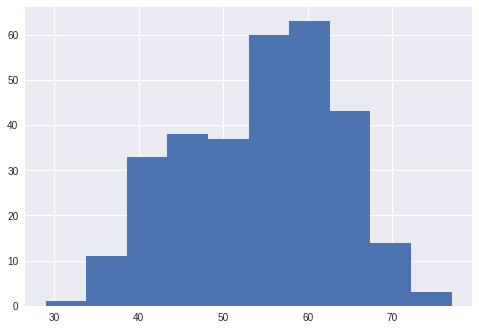

In [16]:
# Check the distribution of age column with histogram
df["age"].hist();

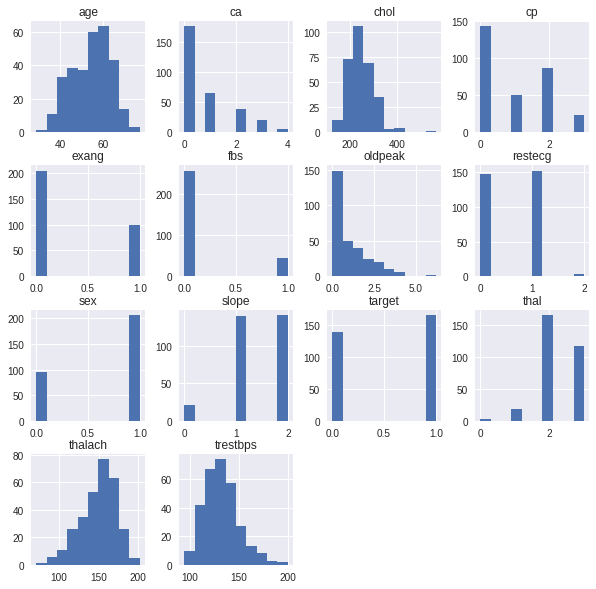

In [17]:
df.hist(figsize = (10,10));

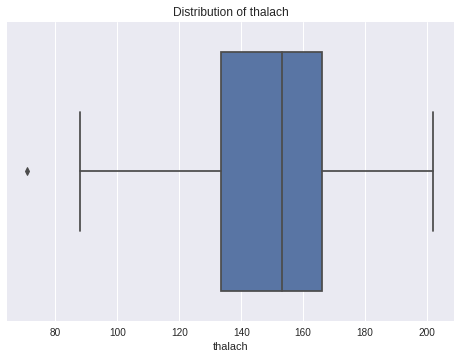

In [18]:
sns.boxplot(x = "thalach", data = df)
plt.title("Distribution of thalach");

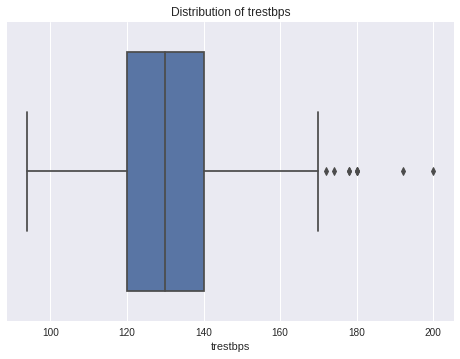

In [19]:
sns.boxplot(x = "trestbps", data = df)
plt.title("Distribution of trestbps");

Looking at the distributions of the features, there don't appear to be outliers. The boxplots of `thalach` and `trestbps` indicates outliers, but the data does not follow a distribution and could benefit from the use of alternative uni-variate techniques including use of a medcouple analysis, a Box-Cox transform, or similar. 

### Heart Disease Frequency per Chest Pain Type

In [20]:
pd.crosstab(df.cp, df.target)

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


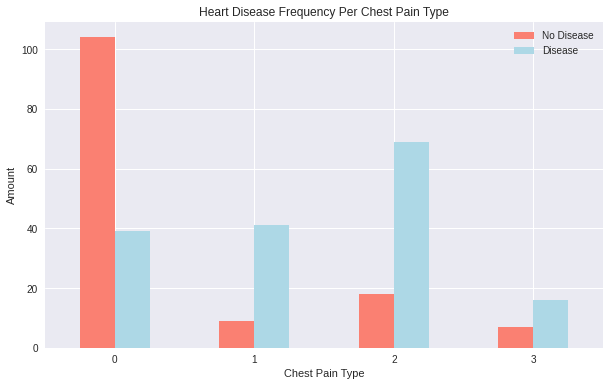

In [21]:
# Make the crosstab more visual
pd.crosstab(df.cp, df.target).plot(kind = "bar",
                                   figsize = (10,6), 
                                   color = ["salmon", "lightblue"])

# Add some communication
plt.title("Heart Disease Frequency Per Chest Pain Type")
plt.xlabel("Chest Pain Type")
plt.ylabel("Amount")
plt.legend(["No Disease", "Disease"])
plt.xticks(rotation = 0);

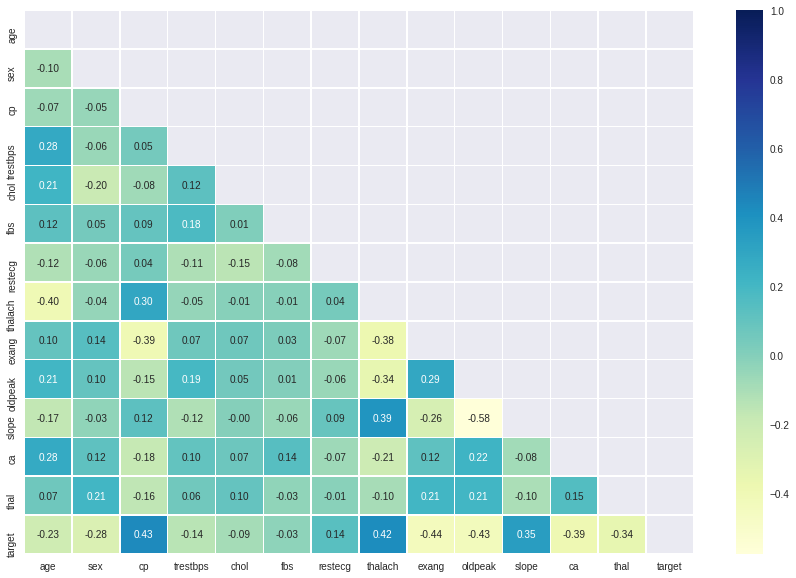

In [22]:
# Let's make our correlation matrix a little prettier
corr_matrix = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(corr_matrix,
                 annot = True,
                 linewidths = 0.5,
                 fmt = ".2f",
                 cmap = "YlGnBu",
                 mask = mask);

## 5. Modeling

In [5]:
# Split data into X and y
X = df.drop("target", axis = 1)
y = df["target"]

In [6]:
# Split into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state = 42)

Now we've got our data split into training and test sets, it's time to build a machine learning model.

We'll train it (find the patterns) on the training set.

And we'll test it (use the patterns) on the test set.

We're going to try 4 different machine learning models:
1. Logistic Regression
2. K-Nearest Neighbors Classifier
3. Random Forest Classifier
4. eXtreme Gradient Boosting Classifier

In [25]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(penalty = "none"),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(), 
          "XGBoost": xgb.XGBClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different sklearn machine learning models
    X_train: training data (no labels)
    X_test: testing data (no labels)
    y_train: training labels
    y_test: test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to teh data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [26]:
model_scores = fit_and_score(models, 
                             X_train, 
                             X_test, 
                             y_train, 
                             y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [27]:
model_scores

{'Logistic Regression': 0.8688524590163934,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8360655737704918,
 'XGBoost': 0.819672131147541}

### Model Comparison

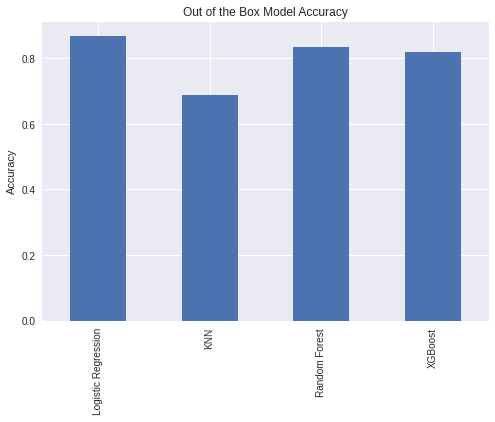

In [28]:
model_compare = pd.DataFrame(model_scores, index = ["accuracy"])
model_compare = model_compare.T

model_compare.plot.bar(title = "Out of the Box Model Accuracy", 
                       legend = None)
plt.ylabel("Accuracy");

Now we've got a baseline model... and we know a models first predictions aren't always what we should base our next steps off. What should we do?

Let's look at the following:
* Hyperparameter Tuning
* Feature Importance
* Confusion Matrix
* Cross-Validation
* Precision
* Recall
* F1 Score
* Classification Report
* ROC Curve
* Area Under the Curve (AUC)
* Precision Recall Curve

### Hyperparameter tuning (by hand)
Let's experiment with hyperparameter tuning K-Nearest Neighbors by hand...

In [29]:
# Let's tune KNN
train_scores = []
test_scores = []

# Create a list of different values for n_neighbors
neighbors = range(1, 21)

# Setup KNN Instance
knn = KNeighborsClassifier()

# Loop through different n_neighbors
for i in neighbors:
    knn.set_params(n_neighbors = i)
    
    # Fit the algorithm
    knn.fit(X_train, y_train)
    
    # Update the training scores list
    train_scores.append(knn.score(X_train, y_train))
    
    # Update the test scores list
    test_scores.append(knn.score(X_test, y_test))

Max KNN score on the test data: 75.41%


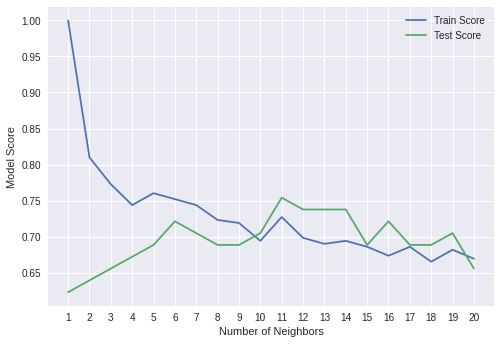

In [30]:
plt.plot(neighbors, train_scores, label = "Train Score")
plt.plot(neighbors, test_scores, label = "Test Score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of Neighbors")
plt.ylabel("Model Score")
plt.legend()

print(f"Max KNN score on the test data: {max(test_scores)*100:.2f}%")

### Hyperparameter tuning with RandomizedSearchCV

We're going to tune:
* `LogisticRegression()`
* `RandomForestClassifier()`
* `XGBClassifier()`

... using RandomizedSearchCV

In [31]:
# Create a hyperparameter grid for Logistic Regression
log_reg_grid = {"C": np.logspace(-4, 4, 20), 
                "solver": ["liblinear"]}

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50), 
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),  
           "min_samples_leaf": np.arange(1, 20, 2)}

# Create a hyperparamter grid for XGBClassifier
xgb_grid = {"booster": ["gbtree", "gblinear", "dart"],
            "learning_rate": np.random.uniform(0,.1,20),
            "tree_depth": [i for i in range(2,9)],
            "n_estimator": [50, 100, 150, 200, 500, 1000]}

Now we've got hyperparameter grids setup for each of our models, let's tuen them using RandomizedSearchCV...

In [32]:
# Standardize dataset since we are using regularized regression
preprocessor = StandardScaler()
X_train_std = preprocessor.fit_transform(X_train)
X_test_std = preprocessor.transform(X_test)

# Tune LogisticRegression
np.random.seed(42)

# Setup random hyperparamter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(n_jobs = -1), 
                                param_distributions= log_reg_grid,
                                cv = 5, 
                                n_iter = 20,
                                verbose = True, 
                                n_jobs = -1)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(X_train_std, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=-1,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=20, n_jobs=-1,
                   param_distributions={'C': arra...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+

In [33]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 1.623776739188721}

In [34]:
rs_log_reg.score(X_test_std, y_test)

0.8524590163934426

Now we've tuned `LogisticRegression`, let's do the same for `RandomForestClassifer`...

In [35]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter searach for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(n_jobs = -1),
                           param_distributions = rf_grid, 
                           cv = 5,
                           n_iter = 20, 
                           verbose = True, 
                           n_jobs = -1)

# Fit random hyperparameter search model for RandomForestClassifier()

rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.4s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [36]:
# Find the best hyperparameters
rs_rf.best_params_

{'n_estimators': 610,
 'min_samples_split': 4,
 'min_samples_leaf': 15,
 'max_depth': 3}

In [37]:
# Evaluate the randomized search RandomForestClassifier model
rs_rf.score(X_test, y_test)

0.8688524590163934

Finally, we'll take a look at `XGBClassifier` and its associated parameters...

In [38]:
xgb_clf = xgb.XGBClassifier(nthread = -1)
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None,
 'nthread': -1}

Let's do a little experimentation with the time it takes to run XGBoost. Let's use the magic function `timeit` to test out how long it runs using n_jobs = -1 for both cross-validation and the `XGBClassifier`

In [39]:
# Setup random seed 
np.random.seed(42)

# Setup random hyperparamter search for XGBClassifier()
optimal_rs_xgb = RandomizedSearchCV(xgb.XGBClassifier(n_jobs = -1),
                           param_distributions = xgb_grid,
                           cv = 5,
                           n_iter = 50,
                           verbose = 0, 
                           n_jobs = -1)

# Fit model
%timeit optimal_rs_xgb.fit(X_train, y_train)

2.24 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
import os
import multiprocessing as mp
import time

print(mp.context.threading.active_count())

8


In [41]:
# Increase parallelization across threads for both cross-validation and the XGBClassifier
n_threads = [i for i in np.arange(1,9)]
cv_xgb_thread_time = []

for i in n_threads:

    # Setup random hyperparamter search for XGBClassifier()
    rs_xgb = RandomizedSearchCV(xgb.XGBClassifier(n_jobs = i, random_state = 42),
                                param_distributions = xgb_grid,
                                cv = 5,
                                n_iter = 50, 
                                n_jobs = i, 
                                random_state = 42)
    start_time = time.time()
    rs_xgb.fit(X_train, y_train)
    execution_time = time.time() - start_time
    cv_xgb_thread_time.append(execution_time)

In [42]:
# Increase parallelization across threads for the XGBClassifier
n_threads = [i for i in np.arange(1,9)]
xgb_thread_time = []

for i in n_threads:

    # Setup random hyperparamter search for XGBClassifier()
    rs_xgb = RandomizedSearchCV(xgb.XGBClassifier(n_jobs = i, random_state = 42),
                                param_distributions = xgb_grid,
                                cv = 5,
                                n_iter = 50, 
                                n_jobs = 1, 
                                random_state = 42)
    start_time = time.time()
    rs_xgb.fit(X_train, y_train)
    execution_time = time.time() - start_time
    xgb_thread_time.append(execution_time)

In [43]:
# Increase parallelization across threads for cross-validation
n_threads = [i for i in np.arange(1,9)]
cv_thread_time = []

for i in n_threads:

    # Setup random hyperparamter search for XGBClassifier()
    rs_xgb = RandomizedSearchCV(xgb.XGBClassifier(n_jobs = 1, random_state = 42),
                                param_distributions = xgb_grid,
                                cv = 5,
                                n_iter = 50, 
                                n_jobs = i, 
                                random_state = 42)
    start_time = time.time()
    rs_xgb.fit(X_train, y_train)
    execution_time = time.time() - start_time
    cv_thread_time.append(execution_time)

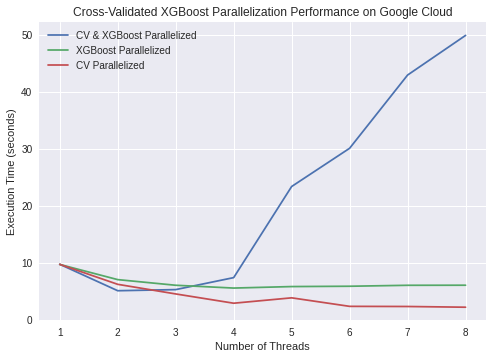

In [44]:
plt.style.use("seaborn")
fig, ax = plt.subplots()
ax.plot(n_threads, cv_xgb_thread_time, label = "CV & XGBoost Parallelized")
ax.plot(n_threads, xgb_thread_time, label = "XGBoost Parallelized")
ax.plot(n_threads, cv_thread_time, label = "CV Parallelized")
plt.legend()
plt.title("Cross-Validated XGBoost Parallelization Performance on Google Cloud")
plt.xlabel("Number of Threads")
plt.ylabel("Execution Time (seconds)");
plt.savefig("CV-XGBoost Parallelization Performance")

In [45]:
rs_xgb.best_params_

{'tree_depth': 7,
 'n_estimator': 1000,
 'learning_rate': 0.09218742350231168,
 'booster': 'gblinear'}

In [46]:
rs_xgb.score(X_test, y_test)

0.8524590163934426

## Hyperparameter Tuning with GridSearchCV

Next, we'll try to improve `LogisticRegression` again using GridSearchCV. This time, we'll also practice using a Pipeline operator to string together a simple pre-processing step and our model.

In [11]:
# Let's package a simple pre-processing step (e.g. StandardScaler) & model into a pipeline object
log_model_pipeline = Pipeline(steps = [("preprocessor", StandardScaler()), 
                          ("model", LogisticRegression())])

# Different hyperparameters for our LogisticRegression model
log_param_grid = {"model__C": np.logspace(-4, 4, 30), 
                "model__solver": ["liblinear"]}

# Fit grid hyperparameter search model
gs_log_model = GridSearchCV(log_model_pipeline, log_param_grid, cv = 5)
gs_log_model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
     

In [12]:
# Check the best hyperparameters
gs_log_model.best_params_

{'model__C': 0.01610262027560939, 'model__solver': 'liblinear'}

In [13]:
gs_log_model.cv_results_

{'mean_fit_time': array([0.00393119, 0.00348907, 0.00354095, 0.00323391, 0.00334759,
        0.00348711, 0.00348411, 0.00346212, 0.00344543, 0.0034884 ,
        0.00352097, 0.00339198, 0.00346508, 0.00345573, 0.00360665,
        0.0038486 , 0.00345798, 0.00350862, 0.00361676, 0.0036798 ,
        0.00377789, 0.0035892 , 0.00346661, 0.00344577, 0.00336142,
        0.0033278 , 0.00332298, 0.00329971, 0.00333762, 0.00334125]),
 'std_fit_time': array([1.29524620e-03, 3.75610971e-04, 1.88489477e-04, 5.59955866e-05,
        1.88688952e-04, 3.32433070e-04, 2.10678431e-04, 1.02688783e-04,
        1.24264843e-04, 1.55846739e-04, 6.74614206e-05, 6.34360112e-05,
        6.75314218e-05, 4.39721947e-05, 1.30849851e-04, 1.40462371e-04,
        2.88879899e-05, 1.02175355e-04, 1.53516640e-04, 1.80437247e-04,
        2.34633421e-04, 1.21365446e-04, 4.92312140e-05, 8.52222334e-05,
        2.84338121e-05, 2.66625747e-05, 6.27910714e-05, 3.08115775e-05,
        1.68984792e-05, 2.49406347e-05]),
 'mean_scor

In [14]:
# Evaluate the grid search LogisticRegression model
gs_log_model.score(X_test, y_test)

0.8852459016393442

### Evaluating our tuned machine learning classifier, beyond accuracy

* ROC Curve, AUC score, Recision-Recall Curve
* Confusion matrix
* Classification Report
* Precision
* Recall
* F1-score

... and it would be great if cross-validation is used where possible.

To make comparisons and evaluate our trained model, first we need to make predictions.

In [15]:
# Make predictions with tuned model 
y_preds = gs_log_model.predict(X_test)

In [16]:
y_preds

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0])

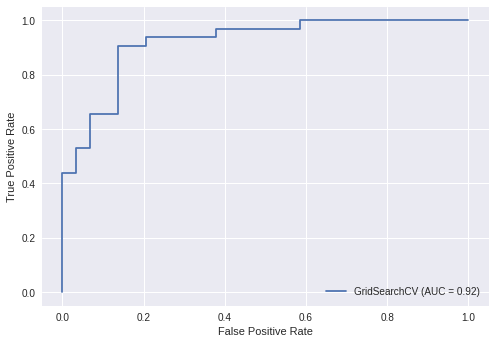

In [17]:
# Plot ROC curve and calculate AUC metric
plt.style.use("seaborn")

plot_roc_curve(gs_log_model, X_test, y_test);

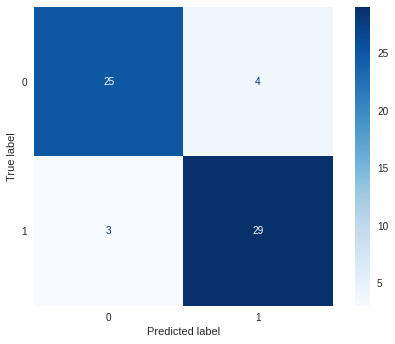

In [18]:
plot_confusion_matrix(gs_log_model, X_test, y_test, cmap = "Blues", values_format = ".3g")
plt.grid(False);

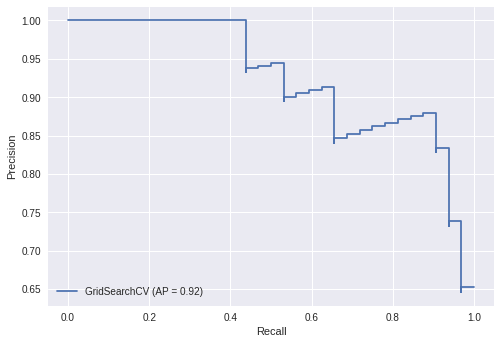

In [19]:
# Plot Precision Recall Curve
plot_precision_recall_curve(gs_log_model, X_test, y_test);

Now we've got a ROC curve, an AUC metric, a confusion matrix, and the precision-recall curve, let's get a classification report as well as cross-validated precision, recall, and f1-score

In [20]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



### Calculate evaluation metrics using cross-validation

We're going to calculate precision, recall, and f1-score of our model using cross-validation and to do so we'll be using `cross_val_score`

In [21]:
# Check best hyperparameters
gs_log_model.best_params_

{'model__C': 0.01610262027560939, 'model__solver': 'liblinear'}

In [22]:
# Create a new classifier with best parameters
clf = LogisticRegression(C = gs_log_model.best_params_["model__C"], 
                         solver = gs_log_model.best_params_["model__solver"])

In [23]:
# Cross-validated accuracy
# Need to scale data
preprocessor = StandardScaler()

pipeline = Pipeline([("preprocessor",preprocessor), ("estimator", clf)])

cv_acc = cross_val_score(pipeline, 
                         X, 
                         y,
                         cv = 5,
                         scoring = "accuracy")

cv_acc = np.mean(cv_acc)
cv_acc

0.8348087431693989

In [24]:
# Cross-validated precision
cv_precision = cross_val_score(pipeline, 
                         X, 
                         y,
                         cv = 5,
                         scoring = "precision")

cv_precision = np.mean(cv_precision)
cv_precision

0.8164965274872396

In [25]:
# Cross-validated recall
cv_recall = cross_val_score(pipeline, 
                         X, 
                         y,
                         cv = 5,
                         scoring = "recall")

cv_recall = np.mean(cv_recall)
cv_recall

0.9030303030303031

In [26]:
# Cross-validated f1-score
cv_f1 = cross_val_score(pipeline, 
                         X, 
                         y,
                         cv = 5,
                         scoring = "f1")

cv_f1 = np.mean(cv_f1)
cv_f1

0.8567286771127686

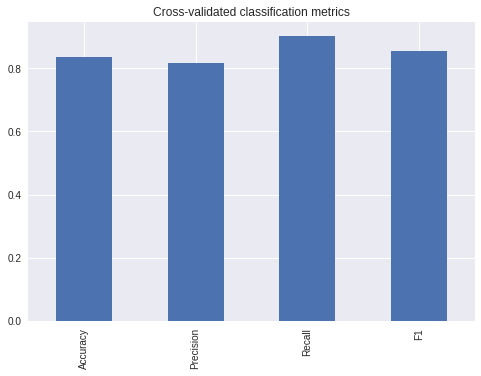

In [27]:
# Visualize cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                           "Precision": cv_precision,
                           "Recall": cv_recall,
                           "F1": cv_f1}, 
                           index = [0])

cv_metrics.T.plot.bar(title = "Cross-validated classification metrics", 
                     legend = False);

### Feature Importance

Feature importance is another way of asking, "which features contributed most to the outcomes of the model and how did they contribute?"

Finding feature importance is different for each machine learning model.

Let's find the feature importance for our LogisticRegression model...

In [28]:
# Fit an instance of LogisticRegression
clf = LogisticRegression(C = gs_log_model.best_params_["model__C"],
                         solver = gs_log_model.best_params_["model__solver"])

clf.fit(X_train, y_train); 

In [29]:
# Check coef_
clf.coef_[0]

array([-0.01376926, -0.20527025,  0.2972168 , -0.01266634, -0.00161348,
        0.00954193,  0.04557643,  0.02461554, -0.16497793, -0.29216865,
        0.13064994, -0.26732958, -0.22283855])

In [30]:
# Match coef's of features to columns 
feature_dict = dict(zip(df.columns, list(clf.coef_[0])))
feature_dict

{'age': -0.013769256773957442,
 'sex': -0.20527024990816134,
 'cp': 0.29721680186170985,
 'trestbps': -0.012666337044651354,
 'chol': -0.0016134800940290019,
 'fbs': 0.009541929226024318,
 'restecg': 0.04557643196450854,
 'thalach': 0.02461554255384497,
 'exang': -0.16497793343956327,
 'oldpeak': -0.2921686457300615,
 'slope': 0.13064993544418196,
 'ca': -0.2673295771955932,
 'thal': -0.22283854936303513}

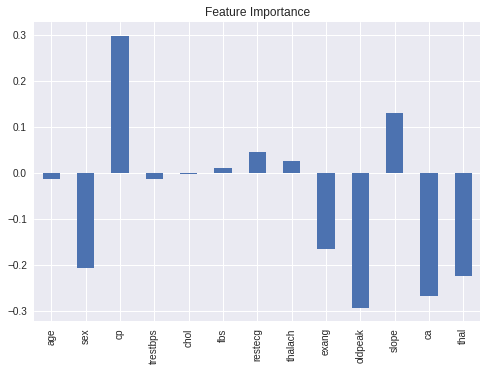

In [31]:
# Visualize feature importance
feature_df = pd.DataFrame(feature_dict, index = [0])
feature_df.T.plot.bar(title = "Feature Importance", legend = False);

In [32]:
pd.crosstab(df["sex"], df["target"])

target,0,1
sex,,
0,24,72
1,114,93


In [33]:
pd.crosstab(df["slope"], df["target"])

target,0,1
slope,,
0,12,9
1,91,49
2,35,107


## 6. Export Model

In [34]:
import pickle

In [35]:
with open('gs_log_model.pkl', 'wb') as model_file:
    pickle.dump(gs_log_model, model_file)